 
L’objectif est d’identifier **au mieux** les clients à risque afin de proposer des actions préventives et améliorer la rétention.   


In [ ]:
# Standard libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Statistiques – Scipy
import scipy
from scipy.stats import chi2_contingency

# Scikit-learn - Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer,
    PolynomialFeatures, MinMaxScaler, StandardScaler,
    FunctionTransformer
)

# Scikit-learn - Feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import (
    SelectKBest, f_regression, chi2, f_classif, VarianceThreshold
)

# Scikit-learn - Model selection & pipeline
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

# Scikit-learn - Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Scikit-learn - Metrique d'Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE


#### Importation des données 

In [2]:
data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


Analyse de la forme des données 

In [7]:
df = data.copy()

In [9]:
df.shape

(7043, 21)

<Axes: ylabel='count'>

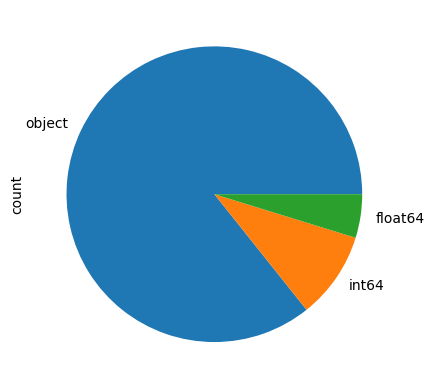

In [10]:
df.dtypes.value_counts().plot.pie()

#### Nettoyages de la data

In [11]:
df.drop(columns=["customerID"], inplace=True) # supression de la variable ID

In [7]:
print(pd.api.types.is_numeric_dtype(df['TotalCharges'])) # la variable totalcharge n'est pas numerique
# data["TotalCharges"].unique() : '29.85', '1889.5', '108.15', ..., '346.45'

False


Convertir la colonne TotalCharges en numerique

In [12]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

Suppresion des valeurs manquantes 

In [13]:
df.isna().sum()  # la variable total charge contient 11 valeurs manquantes


gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [14]:
df.dropna(axis=0, inplace=True) # suppresion des valeurs manquantes

**Histogramme des variables continues**

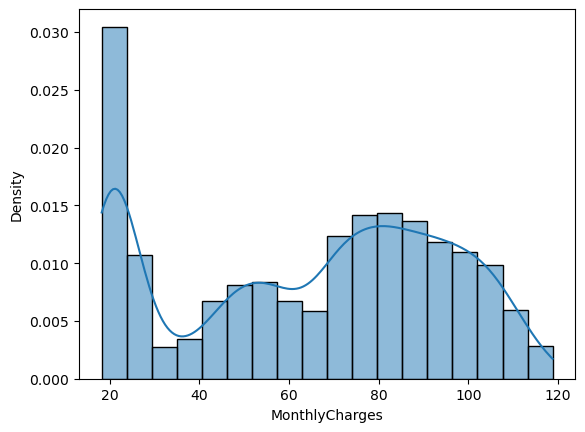

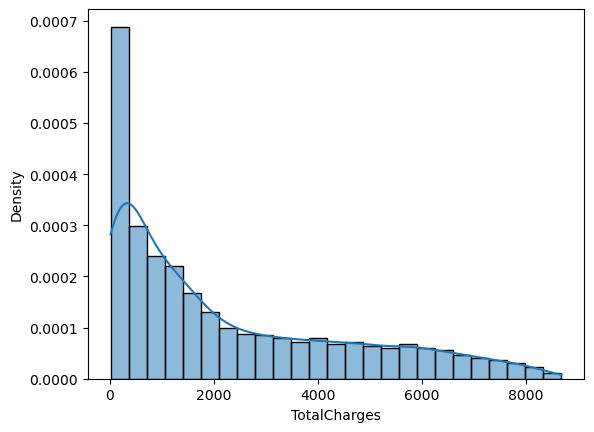

In [15]:
for col in df.select_dtypes('float'):    # mettre ce graphique en subplot
    plt.figure()
    sns.histplot(df[col], kde=True, stat="density")

<Axes: xlabel='tenure', ylabel='Count'>

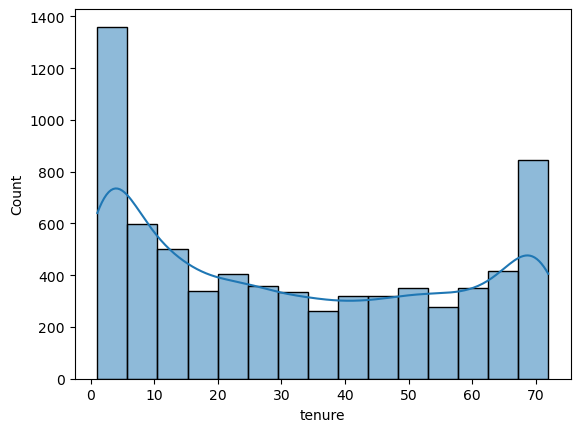

In [16]:
sns.histplot(df["tenure"],kde=True)

Variable Qualitative 

In [17]:
for col in df.select_dtypes('object'):
    print(f"{col :-<30} {df[col].unique()}")

gender------------------------ ['Female' 'Male']
Partner----------------------- ['Yes' 'No']
Dependents-------------------- ['No' 'Yes']
PhoneService------------------ ['No' 'Yes']
MultipleLines----------------- ['No phone service' 'No' 'Yes']
InternetService--------------- ['DSL' 'Fiber optic' 'No']
OnlineSecurity---------------- ['No' 'Yes' 'No internet service']
OnlineBackup------------------ ['Yes' 'No' 'No internet service']
DeviceProtection-------------- ['No' 'Yes' 'No internet service']
TechSupport------------------- ['No' 'Yes' 'No internet service']
StreamingTV------------------- ['No' 'Yes' 'No internet service']
StreamingMovies--------------- ['No' 'Yes' 'No internet service']
Contract---------------------- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling-------------- ['Yes' 'No']
PaymentMethod----------------- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn------------------------- ['No' 'Yes']


Bar plot des variable qualitatives 

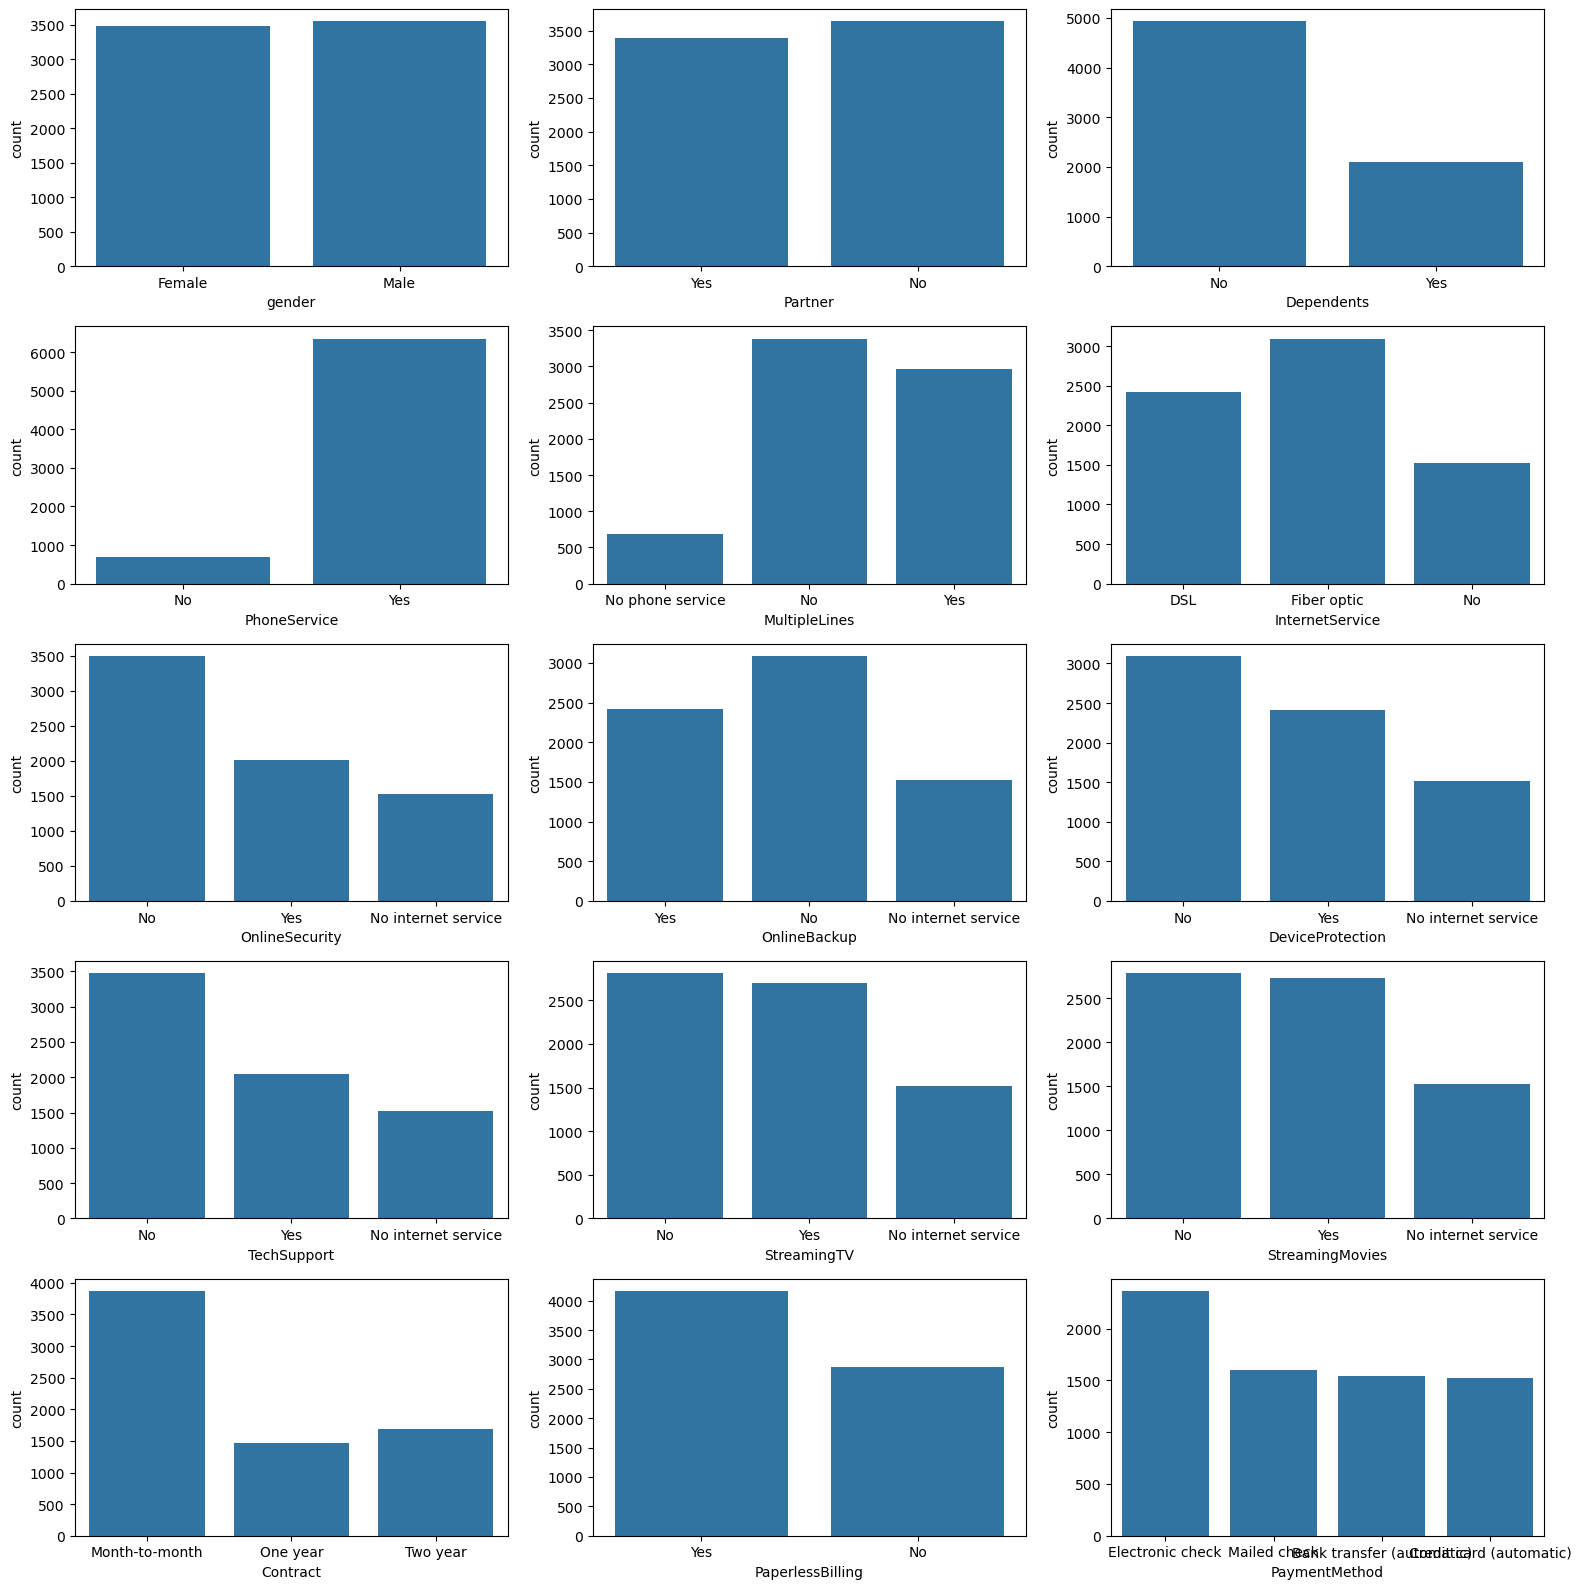

In [22]:
variable_categorielle = [col for col in df.select_dtypes('object')] 
fig, axes = plt.subplots(nrows=5,ncols=3, figsize=(16, 16))  
axes = axes.flatten()  
for ax, col in zip(axes, variable_categorielle):
    sns.countplot(data=df, x=col,ax=ax)

plt.tight_layout()  
plt.show() 

Relation target / Variables Continue

In [18]:
df_churn = df[df["Churn"]=="Yes"]
df_no_churn = df[df["Churn"]=="No"]

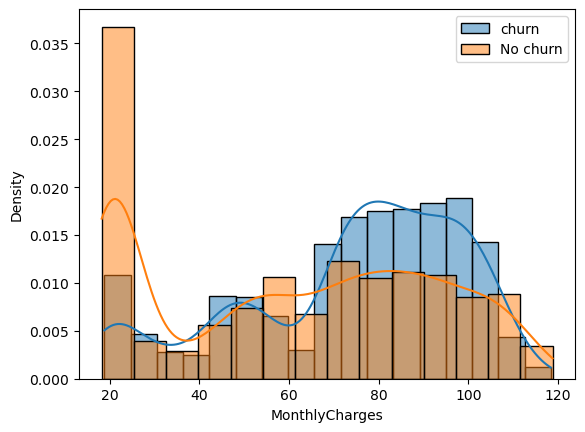

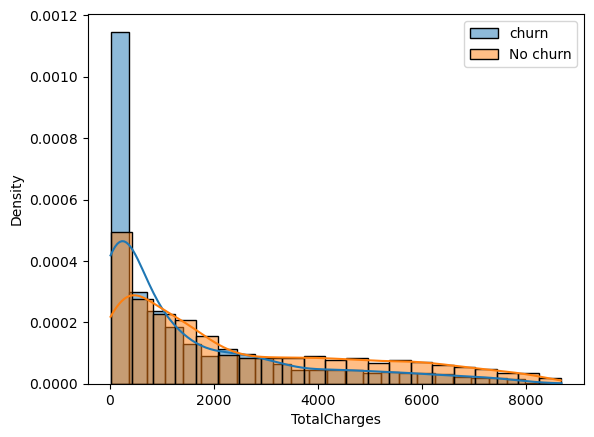

In [19]:
for col in df.select_dtypes('float'):    # mettre ce graphique en subplot
    plt.figure()
    sns.histplot(df_churn[col], kde=True, stat="density", label="churn")
    sns.histplot(df_no_churn[col], kde=True, stat="density", label="No churn")
    plt.legend()

Correlation entre les variables continues

In [ ]:
variable_continue = df.select_dtypes('float').columns.tolist()
df_con = df[variable_continue]
corr = df_con.corr(method = 'pearson')
corr

,MonthlyCharges,TotalCharges
MonthlyCharges,1.000000,0.651065
TotalCharges,0.651065,1.000000


**Interpretation** figure 1   
Les clients qui n'ont pas résilié (No churn) ont une forte concentration autour de faibles montants (environ 20-30).  
Les clients qui ont résilié (churn) sont plus répartis sur des montants moyens à élevés (60-100).  
Cela suggère que les clients avec des charges mensuelles plus élevées sont plus susceptibles de résilier leur contrat.

**Interpretation** figure 2 

Les clients ayant des charges totales faibles (proches de 0) sont majoritairement dans le groupe churn.  
 Cela peut correspondre à des clients ayant résilié rapidement après leur inscription.    
Pour des charges totales plus élevées (au-delà de 2000), la proportion de clients No churn devient dominante.  
La distribution des clients No churn est plus étalée, tandis que celle des clients churn est concentrée sur des   charges totales faibles.

Cela suggère que les clients ayant des charges totales faibles sont plus susceptibles de résilier leur contrat, probablement en raison d'une faible durée d'engagement.

Relation entre Target et le nombre de mois resté dans l'entreprise

<Axes: xlabel='tenure', ylabel='count'>

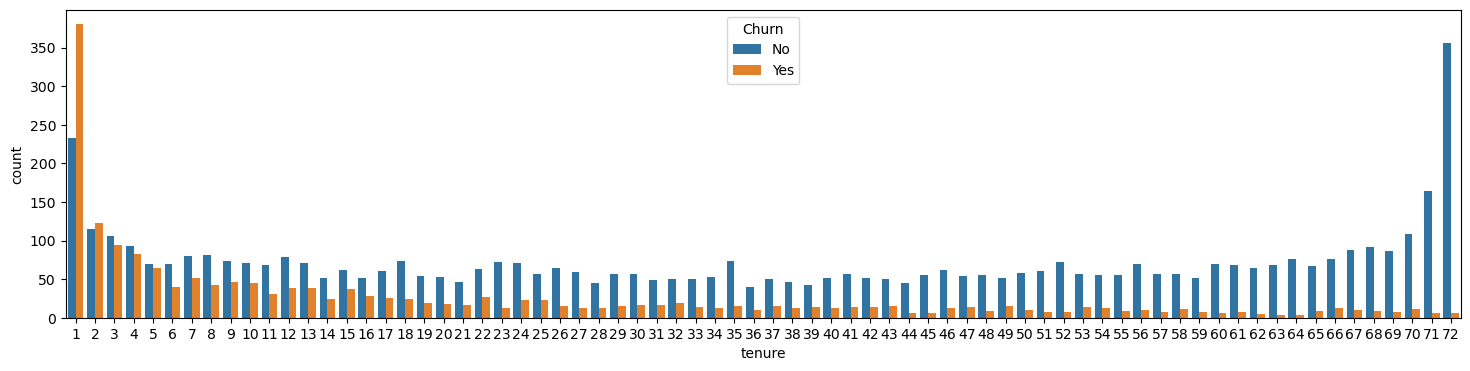

In [20]:
plt.figure(figsize=(18,4))
sns.countplot(data=df, x="tenure", hue="Churn")

**Observations** :

Une forte proportion de clients ayant une faible durée d'abonnement (1 mois) résilient leur contrat (Churn = Yes).  
À mesure que la durée d'abonnement augmente, la proportion de clients qui résilient diminue.  
Les clients ayant une longue durée d'abonnement (au-delà de 60 mois) sont majoritairement dans le groupe Churn = No.

**Interprétation** :  
Les clients ayant une faible durée d'abonnement sont plus susceptibles de résilier leur contrat, ce qui peut indiquer une insatisfaction initiale ou un manque d'engagement.   
En revanche, les clients avec une longue durée d'abonnement sont plus fidèles et moins susceptibles de résilier.

Relation entre Target et les variables categorielles

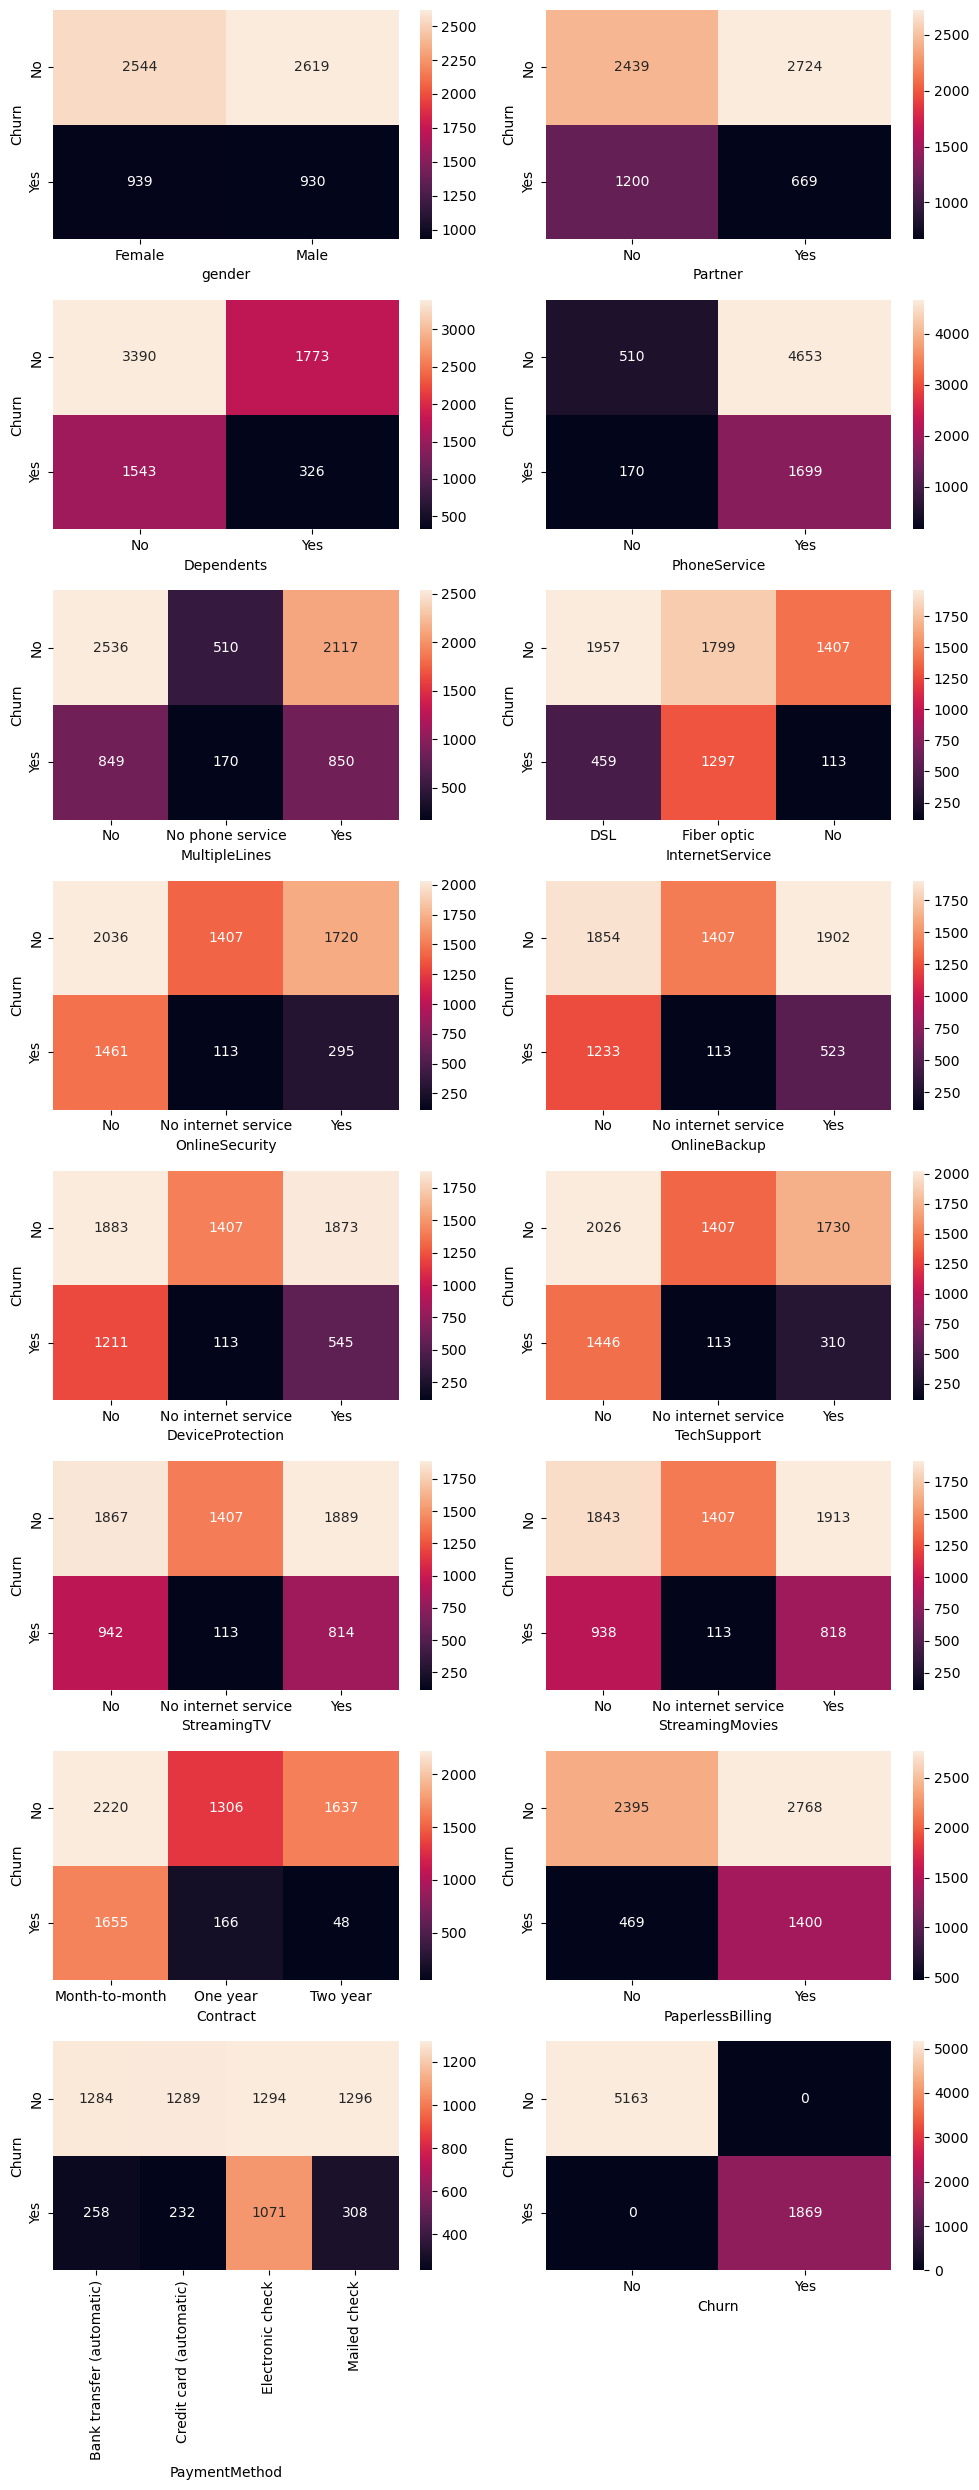

In [23]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10,25))
axes = axes.flatten()  
for ax, col in zip(axes, variable_categorielle):
    sns.heatmap(pd.crosstab(df["Churn"], df[col]), annot=True,fmt='d', ax=ax)
plt.tight_layout()  
plt.show()

### Test d'hypothses 

In [24]:
from scipy.stats import ttest_ind

Test de student 
  - Nous avons plus de 30 observation dans chacune des deux classes
  - Le montant des charges mensuelles pour les personnes qui churnent et ceux qui ne churnent pas sont independant

**Hypothèse 1** : Le montant des charges mensuelles pourrait influencer la résiliation    

Hypothèses :   

- H₀ (Hypothèse nulle) : Il n'y a pas de différence significative entre les montants moyens des charges mensuelles des clients qui churnent et ceux qui ne churnent pas.   
- H₁ (Hypothèse alternative) : Il existe une différence significative entre ces montants.

In [25]:
print("H0:\" Il n'y a pas de différence significative entre les montants moyens des charges mensuelles des clients qui churnent et ceux qui ne churnent pas.\"")
print()
alpha = 0.02
p_value = ttest_ind(df_churn["MonthlyCharges"], df_no_churn["MonthlyCharges"]).pvalue

if p_value < alpha :
    print("Nous avons suffisamment d'evidences pour rejeter H0")
else : 
    print("Nous n'avons pas suffisamment d'evidence pour rejeter H0") 

H0:" Il n'y a pas de différence significative entre les montants moyens des charges mensuelles des clients qui churnent et ceux qui ne churnent pas."

Nous avons suffisamment d'evidences pour rejeter H0


Conclusion  Interprétation : Les personnes qui churnent ne paient pas en moyenne le même montant que celles qui ne churnent pas.

**Hypothèse 2** : La durée d'abonnement pourrait jouer un rôle dans le churn  
- Hypothèse nulle (H₀) : "Il n'existe pas de différence significative entre la durée d'abonnement des clients qui résilient leur contrat et ceux qui ne le résilient pas."
- Hypothèse alternative (H₁) : "La durée d'abonnement influence la résiliation du contrat."

In [26]:
print("H0:\"Il n'existe pas de différence significative entre la durée d'abonnement des clients qui résilient leur contrat et ceux qui ne le résilient pas.\"")
print()
alpha = 0.02
p_value = ttest_ind(df_churn["tenure"], df_no_churn["tenure"]).pvalue

if p_value < alpha :
    print("Nous avons suffisamment d'evidences pour rejeter H0")
else : 
    print("Nous n'avons pas suffisamment d'evidence pour rejeter H0") 

H0:"Il n'existe pas de différence significative entre la durée d'abonnement des clients qui résilient leur contrat et ceux qui ne le résilient pas."

Nous avons suffisamment d'evidences pour rejeter H0


Conclusion :   
Il existe bien une différence significative entre la durée d'abonnement des clients qui résilient leur contrat et ceux qui ne le résilient pas.
Ainsi La durée d'abonnement pourrait jouer un rôle dans le churn

Test Statistique entre les variables categorielle et la variable cible(churn)
  - test de chi2

In [ ]:
def chi2_test(df, target):
    p_values = {}
    
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if col != target:
            contingency_table = pd.crosstab(df[col], df[target])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            p_values[col] = p

    return pd.Series(p_values).sort_values()

# Exemple d'utilisation :
chi2_results = chi2_test(df, "Churn")
print(chi2_results)


Contract            7.326182e-257
OnlineSecurity      1.400687e-184
TechSupport         7.407808e-180
InternetService     5.831199e-159
PaymentMethod       1.426310e-139
OnlineBackup        7.776099e-131
DeviceProtection    1.959389e-121
StreamingMovies      5.353560e-82
StreamingTV          1.324641e-81
PaperlessBilling     8.236203e-58
Dependents           2.019659e-42
Partner              3.973798e-36
MultipleLines        3.567927e-03
PhoneService         3.499240e-01
gender               4.904885e-01
dtype: float64


Les variables associé à un p_value < 0.05 ont une relation statistiquement significative avec la variable cible (churn). Ces variables sont important pour predire si un client resilie ou non son contrat.

Les variables comme Contract, OnlineSecurity, et TechSupport sont fortement liées à la résiliation des contrats et doivent être incluses dans le modèle.  

Les variables gender et Phone Service ont des p-values supérieures à 0.02, indiquant qu'elles ne sont pas significativement corrélées avec la variable cible (Churn). Cela signifie que le sexe du client et la possession d’un service téléphonique n’influencent pas significativement la résiliation du contrat. Par conséquent, ces variables seront supprimées des analyses ultérieures afin d’améliorer la pertinence du modèle.

### Preprocessing 
1. Types de Variables 

 
**Variables ordinales (ordre hiérarchique)** 
- InternetService et Contract

  
**Variables catégorielles (nominales)**  
- Dependents, PhoneService, MultipleLines, OnlineSecurity
- OnlineBackup, DeviceProtection, TechSupport, StreamingTV
- StreamingMovies, PaperlessBilling, PaymentMethod, SeniorCitizen(0,1)


**Variables Continues**   
   * MonthlyCharges et TotalCharges

**Variables discrete** : 
- tenure
   


In [110]:
var_import = ["TotalCharges","MonthlyCharges","OnlineSecurity","TechSupport","InternetService","PaymentMethod","OnlineBackup","DeviceProtection","Contract","tenure"]

2. Encodage des variables et Normalisation 

In [221]:
# Onehot encoder
# categorial_col = ["Dependents","Partner","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling", "PaymentMethod"]

categorial_col = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport","PaymentMethod"]

# Ordinale encoder 
ordinal_col = ["InternetService", "Contract"]
InternetService_order = ['No','DSL','Fiber optic']  # ordre
contract_order = ['Month-to-month', 'One year', 'Two year' ]

# colonne standard scaler = "TotalCharges"
col_standard = ["TotalCharges","tenure" , "MonthlyCharges"]

# colonne min_max_scaler = "tenure" , ""MonthlyCharges"
# col_min_max = ["tenure" , "MonthlyCharges"]
set_config(transform_output='pandas')

3. Construction des Pipelines

In [112]:
Encoder_ordinale_minmax = Pipeline(steps=[("Encoder_ordinale", OrdinalEncoder(categories=[InternetService_order,contract_order])),
                                           ("min_max",MinMaxScaler())])

columns_transformer_encoder_ordinal = ColumnTransformer(
    transformers=[                                                                      
        ("ordinale_min_max",Encoder_ordinale_minmax,ordinal_col)
    ],
    remainder="passthrough",
    verbose_feature_names_out = False
)
columns_transformer_encoder_ordinal

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinale_min_max',
                                 Pipeline(steps=[('Encoder_ordinale',
                                                  OrdinalEncoder(categories=[['No',
                                                                              'DSL',
                                                                              'Fiber '
                                                                              'optic'],
                                                                             ['Month-to-month',
                                                                              'One '
                                                                              'year',
                                                                              'Two '
                                                                              'year']])),
                                                 ('min_max', MinMaxScaler())]),
                                 ['InternetService', 'Contract'])],
                  verbose_feature_names_out=False)

In [113]:
columns_transformer_encoder_cat = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, drop='first'),categorial_col) # drop="first" pour eliminé l'une des colonne afin d'eviter la multicolinéarité
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)
columns_transformer_encoder_cat

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'PaymentMethod'])],
                  verbose_feature_names_out=False)

In [114]:

Colonne_normaliser = ColumnTransformer(
    transformers=[
        ("col_standard_scaler", StandardScaler(), col_standard),
        ("col_min_max",MinMaxScaler(),col_min_max)
    ],
    remainder="passthrough",
    verbose_feature_names_out = False
)
Colonne_normaliser

ColumnTransformer(remainder='passthrough',
                  transformers=[('col_standard_scaler', StandardScaler(),
                                 ['TotalCharges']),
                                ('col_min_max', MinMaxScaler(),
                                 ['tenure', 'MonthlyCharges'])],
                  verbose_feature_names_out=False)

In [222]:

all_columns_transformer= ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(sparse_output=False, drop='first'),categorial_col),
    ("ordinale_min_max",Encoder_ordinale_minmax,ordinal_col),
    ("col_standard_scaler", StandardScaler(), col_standard)
]
)
all_columns_transformer

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'PaymentMethod']),
                                ('ordinale_min_max',
                                 Pipeline(steps=[('Encoder_ordinale',
                                                  OrdinalEncoder(categories=[['No',
                                                                              'DSL',
                                                                              'Fiber '
                                                                              'optic'],
                                                                             ['Month-to-month',
                                                                              'One '
                                                                              'year',
                                                                              'Two '
                                                                              'year']])),
                                                 ('min_max', MinMaxScaler())]),
                                 ['InternetService', 'Contract']),
                                ('col_standard_scaler', StandardScaler(),
                                 ['TotalCharges', 'tenure', 'MonthlyCharges'])])

In [223]:
preprocessor = make_pipeline(all_columns_transformer)
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'PaymentMethod']),
                                                 ('ordinale_min_max',
                                                  Pipeline(steps=[('Encoder_ordinale',
                                                                   OrdinalEncoder(categories=[['No',
                                                                                               'DSL',
                                                                                               'Fiber '
                                                                                               'optic'],
                                                                                              ['Month-to-month',
                                                                                               'One '
                                                                                               'year',
                                                                                               'Two '
                                                                                               'year']])),
                                                                  ('min_max',
                                                                   MinMaxScaler())]),
                                                  ['InternetService',
                                                   'Contract']),
                                                 ('col_standard_scaler',
                                                  StandardScaler(),
                                                  ['TotalCharges', 'tenure',
                                                   'MonthlyCharges'])]))])

#### Partionnement des données 

In [224]:
# pd.set_option('future.no_silent_downcasting', True)
df["Churn"] = df["Churn"].replace({"No": 0, "Yes": 1}).astype(int)
X,y = df.drop(columns="Churn", axis=1), df["Churn"]
X = X[var_import]

In [225]:
y.value_counts(normalize=True)

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

In [ ]:
# X=preprocessor.fit_transform(X)

**Alternative sans SMOTE**

In [226]:
# premiere alternative sans SMOTE , les resultats sont moins bons que avec smote 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=0, shuffle=True )

In [227]:
print(f"{X_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_train.shape=}")
print(f"{y_test.shape=}")

X_train.shape=(5625, 10)
X_test.shape=(1407, 10)
y_train.shape=(5625,)
y_test.shape=(1407,)


In [228]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

**Alternative avec Smote**
 - Les classes sont déséquilibrées, ce qui nécessite des techniques comme SMOTE ou un ajustement des poids

In [229]:
# # Donnée desequilibré , j'ai utilisé la methode SMOTE et cela fonctionne trés bien et donne des bonnes resultats
# 2. deuxieme alternative 
# smote = SMOTE(random_state=0)

smote = SMOTE(random_state = 101)
# k_neighbors=5, sampling_strategy=0.5
X_train_smote, y_train_smote = SMOTE(k_neighbors=5, sampling_strategy=0.9).fit_resample(X_train, y_train)
# X_train, X_test, y_train, y_test = train_test_split(X_oversample,y_oversample, test_size=0.2, random_state=0, shuffle=True )


c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [230]:
print(f"{X_train_smote.shape=}")
print(f"{y_train_smote.shape=}")

X_train_smote.shape=(7847, 16)
y_train_smote.shape=(7847,)


* Sous echantillonnage 

In [36]:
# from imblearn.under_sampling import RandomUnderSampler
# # from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import make_pipeline
# pipeline = make_pipeline(RandomUnderSampler(0.5),SMOTE(0.7))

# X_smote, y_smote = pipeline.fit_resample(X_train, y_train)
# modele.fit(X_smote, y_smote)
# y_pred = modele.predict(X_test)
# f1_score(y_test,y_pred)

In [238]:
kbest_selection = SelectKBest(score_func=f_classif, k=14) 
RandomForest = make_pipeline(kbest_selection,RandomForestClassifier(
        random_state=0,
        max_depth=10,  # Limite la profondeur des arbres
        min_samples_split=5,  # Minimum d'échantillons pour diviser un nœud
        min_samples_leaf=2,  # Minimum d'échantillons dans une feuille
        max_features='sqrt',  # Considère la racine carrée des caractéristiques
        n_estimators=100  # Nombre d'arbres dans la forêt
    ))
SVM = make_pipeline(kbest_selection, SVC(random_state=0, kernel='rbf', C=1.0, gamma='scale', probability=True))
KNN = make_pipeline(kbest_selection, KNeighborsClassifier())
regression_log = make_pipeline(kbest_selection, LogisticRegression())

In [243]:
def evaluation_courbe_apprentissage(model):
    
    # model.fit(X_train_smote, y_train_smote)
    # ypred = model.predict(X_test)
    
    # print(confusion_matrix(y_test, ypred))
    # print(classification_report(y_test, ypred))

    N, train_score, val_score = learning_curve(model, X_train_smote, y_train_smote,
                                               cv=5, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(7,4))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    


In [ ]:
evaluation_courbe_apprentissage(SVM)

In [128]:
dict_of_models = {
    'RandomForest': RandomForest,
    'SVM' : SVM,
    'KNN' : KNN,
    'regression_log':regression_log
}

In [ ]:
for name,model in dict_of_models.items():
    print(name)
    print(50*"*")
    evaluation_courbe_apprentissage(model)

#### Choix du meilleur modele et Optimisation de celeui-ci

In [234]:
hyper_params = {'svc__gamma':[1e-3, 1e-4],  # 'kernel': ['linear', 'rbf'],'gamma': ['scale', 'auto'] autre parametre 
                'svc__C':[1,10,100,1000],
                # 'svc__kernel': ['linear', 'rbf', 'poly'],
                'selectkbest__k':range(4,16)}

In [235]:
grid = RandomizedSearchCV(SVM, 
                          hyper_params,
                          scoring="f1",
                          n_iter=40,
                          cv=8)
grid.fit(X_train_smote, y_train_smote)
print(grid.best_params_)

{'svc__gamma': 0.001, 'svc__C': 1000, 'selectkbest__k': 14}


In [237]:
print(grid.best_score_)

0.766060488489664


##### Random Forest optimisation 

In [174]:
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [5, 10, 15],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'selectkbest__k':range(10,14)
}

In [175]:
grid_search = RandomizedSearchCV(RandomForest,
                                 param_grid,
                                 cv=4, 
                                 scoring='f1',
                                 n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best parameters: {'selectkbest__k': 11, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 10}
Best F1 score: 0.7594927254906257


In [211]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [53]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1033
           1       0.54      0.77      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.80      0.76      0.77      1407



Precision Recall Curve 

In [212]:
precision,recall,threshold = precision_recall_curve(y_test,grid.best_estimator_.decision_function(X_test))

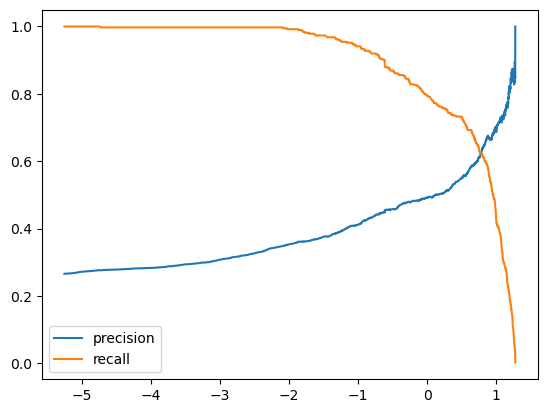

In [213]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

##### Evaluation Finale 

In [214]:
def model_final(model, X, threshold=0):
    return model.decision_function(X)>threshold

In [216]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=0.8)

In [217]:
print(f'{f1_score(y_test, y_pred)=}')
print(f"{recall_score(y_test, y_pred)=}")
print(f"{precision_score(y_test, y_pred)=}")

f1_score(y_test, y_pred)=0.6268656716417911
recall_score(y_test, y_pred)=0.6176470588235294
precision_score(y_test, y_pred)=0.6363636363636364


In [218]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1033
           1       0.64      0.62      0.63       374

    accuracy                           0.80      1407
   macro avg       0.75      0.74      0.75      1407
weighted avg       0.80      0.80      0.80      1407



Conclusion 

Notre objectif était de maximiser la détection des clients susceptibles de résilier leur contrat. Pour cela, notre modèle atteint un recall de 62 %, ce qui signifie qu'il identifie correctement 62 % des clients churners présents dans notre jeu de données. De plus, il affiche une précision de 64 %, indiquant que parmi les clients prédits comme churners, 64 % le sont réellement.
Malgrès les données sont deséquilibré, les resultats ne sont pas mauvais